# Data Downloading, cleaning and storing in an excel file
(Code requires chromedriver.exe to be installed in the working directory and requires selenium to be installed in anaconda)

## Download Raw Medicaid Data

Medicare_data: has been downloaded (using selenium) from https://www.macpac.gov/publication/medicaid-spending-by-state-category-and-source-of-funds/. The raw data is the file that gets downloaded from the website. The clean data is the subset of columns that we need for our project analysis. 

In [1]:
from selenium import webdriver
import time
import os

path_medicare = os.path.abspath('.')

chromeOptions = webdriver.ChromeOptions()
prefs = {"download.default_directory" : path_medicare}
chromeOptions.add_experimental_option("prefs",prefs)

medicare_driver = webdriver.Chrome(executable_path=r"chromedriver.exe", options=chromeOptions)
medicare_driver.maximize_window()
open_url=medicare_driver.get("https://www.macpac.gov/publication/medicaid-spending-by-state-category-and-source-of-funds/")
elem_file=medicare_driver.find_element_by_css_selector('#main > div > header > a:nth-of-type(1)')

elem_file.click()
time.sleep(3)
medicare_driver.quit()

## Clean Medicaid Data
A few states have been removed due to the error encountered while scraping their vaccination data (see description of Vaccination Data section below)

In [2]:
from openpyxl import load_workbook

medicaid_data = load_workbook('EXHIBIT-16.-Medicaid-Spending-by-State-Category-and-Source-of-Funds-FY-2016-millions.xlsx')
raw_sheet = medicaid_data['EX16- McaidSpend']
#re-name sheet and label it as raw data
raw_sheet.title = 'medicaid_raw'

#Create a new sheet for the clean data and insert table titles
clean_sheet = medicaid_data.create_sheet("medicaid_clean")
clean_sheet['A1']='State'
clean_sheet['B1']='State Medicare Funding FY 2016'

states_to_copy=['Massachusetts', 'Missouri', 'Kansas', 'Rhode Island', 'South Dakota', 'Georgia', 'New Jersey', 'Mississippi', 'Oklahoma', 'Nebraska', 'Virginia', 'North Carolina', 'Indiana', 'Maine', 'Utah', 'Wisconsin', 'Montana', 'Arkansas', 'Vermont', 'Delaware', 'New Mexico', 'Idaho', 'Illinois', 'Nevada', 'Pennsylvania', 'Oregon', 'South Carolina', 'Alaska', 'Alabama', 'Kentucky', 'Arizona', 'New Hampshire', 'Iowa', 'New York', 'Tennessee', 'Texas', 'West Virginia', 'California', 'Wyoming', 'North Dakota', 'Maryland', 'Colorado']

#Copy the state name and the medicaid funding to the appropriate columns in the clean sheet
state_count=2
for row in raw_sheet['A5:L55']:
    for cell in row:
        if cell.value in states_to_copy:
            clean_sheet['A{}'.format(state_count)]=cell.value
            clean_sheet['B{}'.format(state_count)]=raw_sheet['L{}'.format(cell.row)].value
            state_count+=1


medicaid_data.save('group_04_data.xlsx')

## Download Raw Vaccination Data 

Vaccination_data: has been web scraped from https://www.aap.org/en-us/advocacy-and-policy/aap-health-initiatives/immunizations/Pages/Across-America.aspx. The clean data is obtained by writing a python code that opens the website, clicks on a state, obtains the source code, scrapes the value under the heading “Combined 7-vaccine series in children 19-35 months old (Includes ≥4 DTaP doses, ≥3 Polio doses, ≥1 MMR dose, Hib full series, ≥3 HepB doses, ≥1 Varicella dose, and ≥4 PCV doses)”, "Religious exemptions allowed?", "Philosophical exemptions allowed?", then clicks the "close button" to close out the pop up, clicks on the next state and so on.
This gives the % of children in that state who have received all 7-vaccines. The code also scrapes data about if religious and philosophical exemptions are allowed in the state.
The raw data is the html parser obtained by clicking on Alaska. The desired value is in: 

(p) class="bar-value">68.8%(/p) since 68.8% of children in Alaska were vaccinated for all 7 doses. A few states are not included in the file since those states have other clickable items(Eg: exclamation points) on the website. Due to this the program is not able to click on those states and retrieve the appropriate data.

In [3]:
import bs4
import pandas as pd

#open a web browser
vacci_driver = webdriver.Chrome(executable_path=r"chromedriver.exe")
vacci_driver.maximize_window()
#open the url
open_url=vacci_driver.get("https://www.aap.org/en-us/advocacy-and-policy/aap-health-initiatives/immunizations/Pages/Across-America.aspx")
#click on 'Alaska', obtain the source code and close browser
elem_alaska=vacci_driver.find_element_by_css_selector('#svg-us > g.states-group > path[data-name="Alaska"]')
elem_alaska.click()
alaska_html=vacci_driver.page_source
vacci_driver.quit()
#put the source code in the beautiful and pretify it
alaska_soup=bs4.BeautifulSoup(alaska_html, "html.parser")
alaska_soup_pretty=alaska_soup.prettify()

#create a dataframe with the html parser and state name
df_vacci_raw=pd.DataFrame(columns=['Sample State', 'Sample raw html parser'])
df_vacci_raw=df_vacci_raw.append({'Sample State': 'Alaska', 'Sample raw html parser': str(alaska_soup_pretty)}, ignore_index=True)

#write the dataframe to excel file
current_book = load_workbook('group_04_data.xlsx')
vacci_writer=pd.ExcelWriter('group_04_data.xlsx', engine='openpyxl')
vacci_writer.book=current_book
df_vacci_raw.to_excel(vacci_writer, 'vaccination_raw', index=False)

vacci_writer.save()

## Clean Vaccination Data

In [4]:
#Get a list of all the states for which the website has vaccination data
states_driver = webdriver.Chrome(executable_path=r"chromedriver.exe")
states_driver.get("https://www.aap.org/en-us/advocacy-and-policy/aap-health-initiatives/immunizations/Pages/Across-America.aspx")

html_for_states=states_driver.page_source

states_driver.quit()
state_soup=bs4.BeautifulSoup(html_for_states, "html.parser")
states=state_soup.select('#svg-us > g.states-group > path')

states_list=[]
for i in range(len(states)-1):
    new_state=states[i].get('data-name')
    states_list.append(new_state)

#Eliminate States that are throwing errors
states_not_working=['Connecticut', 'District of Columbia', 'Florida', 'Hawaii', 'Louisiana', 'Michigan', 'Minnesota', 'Ohio', 'Washington']
states_to_scrape=list(set(states_list) - set(states_not_working))


#Create an empty dataframe that will store scraped data
df_vacci_clean=pd.DataFrame(columns=['State','%Children with combined 7-vaccine series','Religious Exemption allowed?', 'Philosophical Exemption allowed?'])


#Open a browser, click on every state, obtain the source code, pull the % of children vaccinated/exemptions allowed, click on the close button, click on the next state and repeat
vacci_clean_driver = webdriver.Chrome(executable_path=r"chromedriver.exe")
vacci_clean_driver.maximize_window()
vacci_clean_driver.get("https://www.aap.org/en-us/advocacy-and-policy/aap-health-initiatives/immunizations/Pages/Across-America.aspx")

for statename in states_to_scrape:
    str1 = "#svg-us > g.states-group > path[data-name=\""+statename +"\"]"
    to_click = vacci_clean_driver.find_element_by_css_selector(str1)
    to_click.click()
    data_html=vacci_clean_driver.page_source
    to_close=vacci_clean_driver.find_element_by_css_selector('#vaccination-ig > div.close-btn > img')
    to_close.click()

    data_soup=bs4.BeautifulSoup(data_html, "html.parser")
    statistic_data_point=data_soup.select('#states-national-ig > div.chart-wrap > div:nth-of-type(3) > div:nth-of-type(2) > div.bar-chart.state-bar > p')
    statistic=statistic_data_point[0].getText()

    religious_data_point = data_soup.select('#vaccination-ig > div.exemptions-section > div:nth-of-type(2) > p.circle')
    religious_stat=religious_data_point[0].getText()

    philosophical_data_point = data_soup.select('#vaccination-ig > div.exemptions-section > div:nth-of-type(3) > p.circle')
    philosophical_stat=philosophical_data_point[0].getText()
#Store data points in the 'df_vacci_clean' dataframe 
    df_vacci_clean = df_vacci_clean.append({'State': statename, '%Children with combined 7-vaccine series': statistic, 'Religious Exemption allowed?': religious_stat, 'Philosophical Exemption allowed?': philosophical_stat},ignore_index=True)

vacci_clean_driver.quit()

#store dataframe to excel
current_book = load_workbook('group_04_data.xlsx')
vacci_clean_writer=pd.ExcelWriter('group_04_data.xlsx', engine='openpyxl')
vacci_clean_writer.book=current_book
df_vacci_clean.to_excel(vacci_clean_writer, 'vaccination_clean', index=False)

vacci_clean_writer.save()



## Download Education Data

We are pulling the Public School Enrollment in 2013-14 data from the Civil Rights Data Collection (CRDC) using the CRDC API. This dataset gives information about the number of students enrolled in public education in 2013-14 by race/ethnicity, gender and program status. 
Since we are looking at different factors having an effect on immunization rates per state, one of the factors we decided to look at was the school enrollment per state which can be a good estimator of the importance of education in a state. Thus, we are pulling the total number of public school enrollments per state using the CRDC API to include in our analysis. APIs for later years weren’t available so we decided to use the 2013-14 data as a good estimate of the total public school enrollments. 
CRDC API: api.ed.gov/data/crdc_enrollment_2013-14?api_key=DEMO_KEY1

In [5]:
from urllib.request import urlopen
import json
import numpy as np

#Pulling data from the API
data_set = []
for i in range(1,11):
    url = 'https://api.ed.gov/data/crdc_enrollment_2013-14?per_page=10000&page=' + str(i) + '&api_key=FYOEBgpdzH5lF3mnd3Zpgho5IXUF1RhA05iBIoRR'
    r = urlopen(url).read().decode('UTF-8')
    raw = json.loads(r)
    final = raw['resources']
    for resources in final:
        data_set.append(resources)

#Selecting keys and values we need 
new = []
for object in data_set:
    keys = ['LEA_STATE', 'SCH_NAME', 'LEA_NAME', 'TOT_ENR_F', 'TOT_ENR_M']
    new1 = [object[k] for k in keys]
    new.append(new1)

#Converting list to array to dataframe
new_array = np.asarray(new)
new_array.reshape((95507,5))
new_array2 = pd.DataFrame(new_array)
new_df = pd.DataFrame(new_array, columns=['State', 'Sch_Name', 'Lea_Name', 'Tot_F', 'Tot_M'])
df_edu = pd.DataFrame()
df_edu[['State', 'Tot_F', 'Tot_M']] = new_df[['State', 'Tot_F', 'Tot_M']]
df_edu['Tot_F'] = df_edu['Tot_F'].astype(np.int64)
df_edu['Tot_M'] = df_edu['Tot_M'].astype(np.int64)
df_edu = df_edu.groupby(['State'], as_index=False).sum()

#Writing to excel
current_book = load_workbook('group_04_data.xlsx')
edu_writer=pd.ExcelWriter('group_04_data.xlsx', engine='openpyxl')
edu_writer.book=current_book
#write raw data to excel
new_df.to_excel(edu_writer, 'education_test', index=False)
new_array2.to_excel(edu_writer, 'education_raw', index=False)
#write clean data to excel
df_edu.to_excel(edu_writer, 'education_clean', index=False)

edu_writer.save()

# Data Vizualization and Interpretation

## Preparing a singletable that contains all (medicaid, education and vaccination) data 

In [6]:
#Abbreviating State name
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

df_medicaid = pd.read_excel("group_04_data.xlsx", sheet_name='medicaid_clean')
df_medicaid=df_medicaid.replace({"State": us_state_abbrev})
df_vacci_clean=df_vacci_clean.replace({"State": us_state_abbrev})

In [7]:
#Preparing a single table that contains all data
df_to_visualize=df_medicaid.merge(df_vacci_clean, on='State')
df_to_visualize=df_to_visualize.merge(df_edu, on='State',how='left')

In [8]:
#Strip % so that the %of children vaccinated is just a number(Eg: make 68.8% to 68.8)
df_to_visualize['%Children with combined 7-vaccine series']=df_to_visualize['%Children with combined 7-vaccine series'].str.rstrip('%')
#Changing datatypes for ease of visualization
df_to_visualize['%Children with combined 7-vaccine series'] = df_to_visualize['%Children with combined 7-vaccine series'].astype(np.float64)


In [9]:
#Making the data within each column consistent
df_to_visualize.replace(to_replace="Yes (day, nursery, and preschools only)", value="Yes", inplace=True)

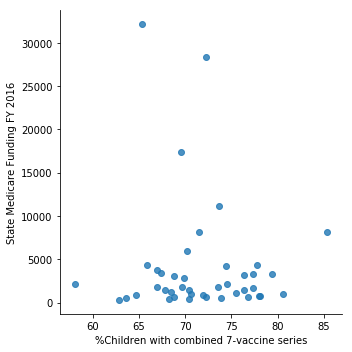

In [16]:
#Vaccination% against Medicaid Spending
import seaborn as sns
print(sns.lmplot(x='%Children with combined 7-vaccine series', y='State Medicare Funding FY 2016',data=df_to_visualize, fit_reg=False))

The graph above shows no trend between State Medicaid Funding and % children vaccinated. The following can be seen in the graph:
1.	States with higher vaccination rates(>75%) have less than $10,000 Medicaid funding 
2.	States with lower vaccination rates (<75%) have a mix of more than $10,000 and less than $10,000 in Medicaid funding
3.	States with higher Medicaid funding (>$10,000) have lower vaccination rates (<75%)
4.	States with lower Medicaid funding (<$10,000) have a mix of lower and higher vaccination rates
Thus, we see that while there is an inverse trend indicated by 1 and 3, there is no trend across the entire graph/data. Therefore, we can conclude that State Medicaid Funding is not correlated with vaccination rates.


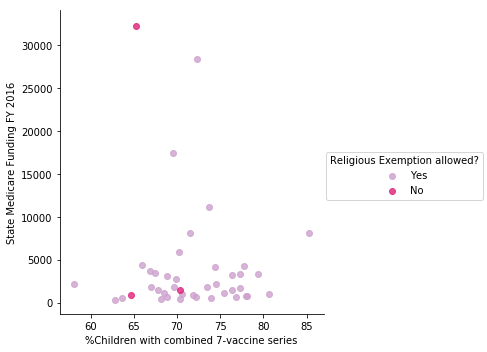

In [12]:
#Vaccination% against Medicaid Spending sorted by Religious Exemptions
print(sns.lmplot(x='%Children with combined 7-vaccine series', y='State Medicare Funding FY 2016',data=df_to_visualize, fit_reg=False, hue='Religious Exemption allowed?', palette="PuRd"))

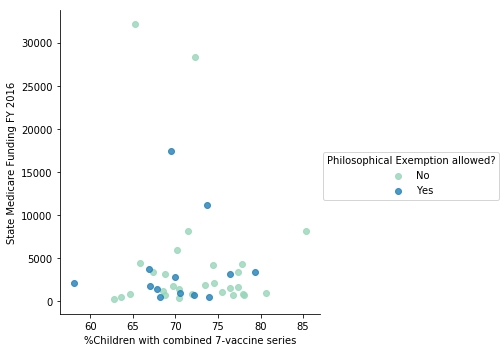

In [13]:
#Vaccination% against Medicaid Spending sorted by Philosophical Exemptions
print(sns.lmplot(x='%Children with combined 7-vaccine series', y='State Medicare Funding FY 2016',data=df_to_visualize, fit_reg=False, hue='Philosophical Exemption allowed?', palette="YlGnBu"))

Among the states with and without religious exemptions, there is once again a lack of trend between the State Medicaid Funding and % children vaccinated. The same applies to states with and without philosophical exemptions. Thus, segregating the data by exemptions reinforces the lack of trend between State Medicaid Funding and % children vaccinated.

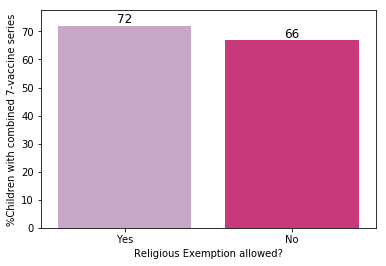

In [14]:
#Religious Exemptions plotted against avg%children vaccinated
ax_religious=sns.barplot(x='Religious Exemption allowed?', y='%Children with combined 7-vaccine series', data=df_to_visualize,palette="PuRd", errwidth=0)
for p in ax_religious.patches:
    ax_religious.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')


In the bar chart above, we observe that religious exemptions do not encourage lower vaccination rates (as opposed to intuition). The average %children vaccinated is higher for states that do allow for religious exemptions. This is probably due to the large difference in the number of states in the states with(n=39) and without(n=3) religious exemptions. 

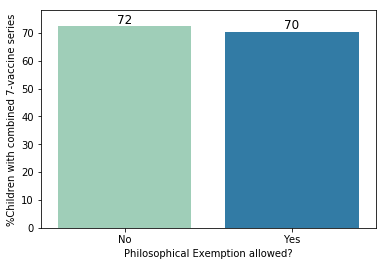

In [15]:
#Philosophical Exemptions plotted against avg%children vaccinated
ax_philosophical=sns.barplot(x='Philosophical Exemption allowed?', y='%Children with combined 7-vaccine series', data=df_to_visualize, palette="YlGnBu", errwidth=0)
for p in ax_philosophical.patches:
    ax_philosophical.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

In the bar chart above, we see that the states with philosophical exemptions have a lower average %children vaccinated. In order to determine if the difference is statistically significant, we need to find out the p-value.

In [30]:
#finding p-value to see if the difference is statistically different
import scipy.stats as stats
df_with_phil_exemption= df_to_visualize[df_to_visualize['Philosophical Exemption allowed?'] == 'Yes']
sample_with_exemption=list(df_with_phil_exemption['%Children with combined 7-vaccine series'])
df_no_phil_exemption= df_to_visualize[df_to_visualize['Philosophical Exemption allowed?'] == 'No']
sample_no_exemption=list(df_no_phil_exemption['%Children with combined 7-vaccine series'])
t_val, p_val=stats.ttest_ind(sample_with_exemption, sample_no_exemption)
print ("p-value =","%.3f" % p_val)

p-value = 0.261


The p-value is 0.26 which is much greater than 0.05. This means that the difference between the two groups have more than a 5% probability of occurring by chance alone. Thus, the difference between the average %children vaccinated between states with and without philosophical exemptions is not significant. This tells us that allowing for philosophical exemptions does not influence the % children vaccinated. 

Project Summary:

Reflection of group members: 
Ayushi: I started off in the class with no experience in python and had taken an introductory course in SQL programming before. The first few course modules helped me get comfortable with python and after the first two weeks I started to enjoy coding in python. The class labs helped me with understanding the nuances of certain functions but it was the project that helped me code in a specific context to achieve a tangible goal. 
I remember sitting down in office hours and going over the interactive nature of one of my website data sources and how beautiful soup would be inadequate to extract data from the web page (https://www.aap.org/en-us/advocacy-and-policy/aap-health-initiatives/immunizations/Pages/Across-America.aspx). While the final excel is a clean and organized data that seems only “moderately complex”, obtaining the data took me a couple of weeks. The website uses a javascript at the back end and extracting information from there wasn’t really an option. That is when I decided to learn and use the selenium library to automate the process of clicking on a state, obtaining the source code, closing out of that pop up, clicking on the next state and so on. My selenium experience was both challenging and rewarding but it helped me understand the infinite possibilities within the world of data scraping. 
This course has helped me appreciate python, its advantages and its use in healthcare. As an aspiring healthcare data analyst, I am glad I took this course and chose vaccination as my project topic.
